##Installing and importing Gurobi and other packages
https://support.gurobi.com/hc/en-us/articles/4409582394769-Google-Colab-Installation-and-Licensing

Academic license: https://www.gurobi.com/features/academic-wls-license/

In [1]:
#Import the installed gurobi package
import gurobipy as gp
from gurobipy import GRB

Sofia's License

In [2]:
# Create an environment with your WLS license
params = {
"WLSACCESSID": '55a5ea8e-fd86-495b-9de2-e77df5699175',
"WLSSECRET": '4fbc0218-58d9-423e-9120-ea4b8e8100a0',
"LICENSEID": 2441550,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2441550
Academic license 2441550 - for non-commercial use only - registered to so___@tum.de


In [3]:
#Import packages for data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import random
import numpy as np

## Importing and preparing the dataset

##### **Data Importing**

In [4]:
#Read data from excel file
df_vehicle = pd.read_excel('https://github.com/chialingyang7718/AS-in-OM/raw/main/Data.xlsx', sheet_name='S2-1 Vehicle projects',skiprows = [1])
df_parameters = pd.read_excel('https://github.com/chialingyang7718/AS-in-OM/raw/main/Data.xlsx', sheet_name='S2-2 Modified parameters')
df_before2025 = pd.read_excel('https://github.com/chialingyang7718/AS-in-OM/raw/main/Data.xlsx', sheet_name='S2-3 Decisions before 2025',skiprows = [1])
df_demand = pd.read_excel('https://github.com/chialingyang7718/AS-in-OM/raw/main/Data.xlsx', sheet_name='Fig 2 Demand', skiprows = 2)
df_demand=df_demand.iloc[:,1:]
df_emissions = pd.read_excel('https://github.com/chialingyang7718/AS-in-OM/raw/main/Data.xlsx', sheet_name='Fig 4 NPV, emissions (exceed.)', skiprows = [0,1,3]+[i for i in range(11,20)])
df_emissions = df_emissions.drop(columns = ["Unnamed: 0"])

#Rename column names
df_vehicle.rename(columns={'Unnamed: 0':'Vehicle projects', 'Production Cost [€/vehicle]':'Production Cost', 'Tailpipe emissions [g CO2/km]':'Emissions', 'Sales revenues [€/vehicle]':'Sales revenues'}, inplace=True)
df_before2025.rename(columns={'Vehicle Projects decided before 2025':'Vehicle projects', ' Decided before [binary]':'Decided before', 'Production resources decided before 2025':'Production resources', 'Capacity of production resource in 2025 [vehicles/year]':'Capacity in 2025'}, inplace=True)
df_emissions.rename(columns={'Unnamed: 1':'Scenario'}, inplace=True)

#Separating the df_before2025 in 2 tables
df_vehicleprojectsbefore2025 = df_before2025[["Vehicle projects", "Decided before"]].dropna()
df_productionresourcesbefore2025 = df_before2025[["Production resources", "Capacity in 2025"]]


##### **Data Processing**

In [5]:
#Define the start of planning period here. Assume decisions in the StartofPlanning have already made. 
StartofPlanning = 2025

#Extract the SOP, market segment and resource
df_vehicle['SOP'] = df_vehicle['Vehicle projects'].str.extract('(\d+)').astype('int')
df_vehicle['Market Segments'] = df_vehicle['Vehicle projects'].str.extract('(\w+)\_')
df_vehicle['Resource'] = df_vehicle['Vehicle projects'].str.replace(r'low_', '').str.strip()
df_vehicle['Resource'] = df_vehicle['Resource'].str.replace(r'high_', '').str.strip()
df_vehicle = df_vehicle.set_index("Vehicle projects")


#filtering the emissions threshold
df_emissionsthreshold = df_emissions[df_emissions["Scenario"] == "Threshold"]
df_emissionsthreshold = df_emissionsthreshold.set_index('Scenario')
df_emissionsthreshold = df_emissionsthreshold.transpose()


## Optimization part with Gurobi
Example notebook from Gurobi: https://www.gurobi.com/jupyter_models/?_sft_difficulty_level=introductory \
Model from Thies: https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Fjiec.13228&file=jiec13228-sup-0001-S1.pdf


### Sets and indices
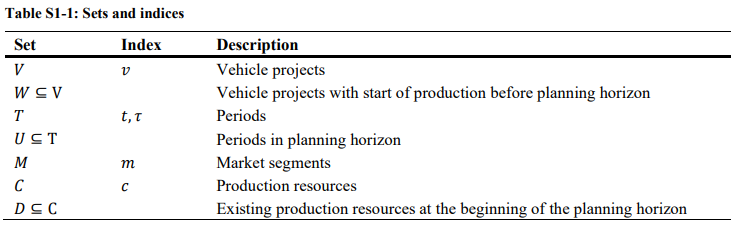

In [6]:
# list of vehicle projects
V = df_vehicle.index.tolist()
W = df_vehicle[df_vehicle['SOP'] <= StartofPlanning].index.tolist() 

# list of periods
T = df_vehicle['SOP'].unique().astype('int')
U = [i for i in T if i > StartofPlanning]

# list of market segments
M = df_vehicle['Market Segments'].unique()

# list of production resources
C = df_vehicle['Resource'].unique()
D = df_productionresourcesbefore2025[df_productionresourcesbefore2025["Capacity in 2025"] > 0]["Production resources"].values[:]

### Parameters
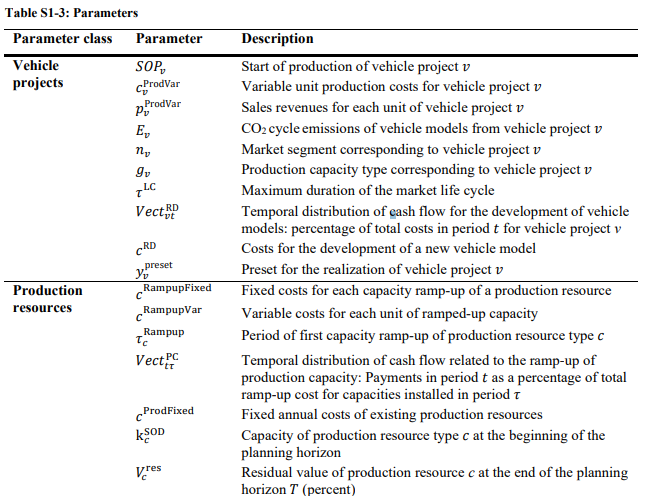

In [7]:
#Parameter related to Vehicle projects
SOPv = df_vehicle["SOP"]
cvProdVar = df_vehicle["Production Cost"]
pvProdVar = df_vehicle["Sales revenues"]
Ev = df_vehicle["Emissions"]
nv = df_vehicle["Market Segments"]
gv = df_vehicle['Resource']
tauLC = df_parameters[df_parameters["Parameter"] == "Tau^LC"]["Value"].values[0]
cRD = df_parameters.loc[df_parameters["Parameter"] == "C_v^Development","Value"].values[0]
yvpreset = df_vehicleprojectsbefore2025.set_index("Vehicle projects")

#Create VectvtRD
tauRD = 3 # Assume development period is 3 years
VectvtRD_list = []
for i in V:
    if SOPv[i] > StartofPlanning:
        for t in range(SOPv[i]-tauRD, SOPv[i]):
            row = {"Vehicle Project": i, "Period": t, "Percentage": 1/tauRD} #Assume development phase ends right before SOP
            VectvtRD_list.append(row)
    else:
        row = {"Vehicle Project": i, "Period": SOPv[i], "Percentage": 0} #No development cost of projects that are earlier than start of planning should be considered 
        VectvtRD_list.append(row)
VectvtRD = pd.DataFrame(VectvtRD_list)
VectvtRD.set_index(['Vehicle Project','Period'], inplace=True)

In [8]:
#Parameters related to production resources
cRampupFixed = df_parameters[df_parameters["Parameter"] == "C^rampupFixed"]["Value"].values[0]
cRampupVar = df_parameters[df_parameters["Parameter"] == "C^rampupVar"]["Value"].values[0]
cProdFixed = df_parameters[df_parameters["Parameter"] == "C^prodFixed"]["Value"].values[0]
kcSOD = df_productionresourcesbefore2025.set_index("Production resources")
Vcres = 0.05 #Assume the residual value of resources remains 5% at the end of planning period

#Create taucRampup
Unique = pd.Series(C,name='Resource')
Period = Unique.str.extract('(\d+)').astype('int')
taucRampup = pd.concat([Unique, Period], axis=1)
taucRampup.rename(columns={0:'First Rampup year'}, inplace=True)
taucRampup = taucRampup.set_index('Resource')

#Create VectttauPC
tauRampup = 5 #Asssume the total rampup cashflow equally distributed over 5 years 
VectttauPC_list = []
for t in T:
    if t > StartofPlanning:
        for i in range(t-tauRampup,t):
            row = {"First Rampup year(tau)": t, "Period(t)": i, "Percentage": 1/tauRampup} # Assume rampup cost occurs right before first ramp up
            VectttauPC_list.append(row)
    else:
        row = {"First Rampup year(tau)":t, "Period(t)": t, "Percentage": 0} # No rampup cost should be considered before start of planning since it is already determined
        VectttauPC_list.append(row)
VectttauPC = pd.DataFrame(VectttauPC_list)
VectttauPC.set_index(["First Rampup year(tau)",'Period(t)'], inplace=True)

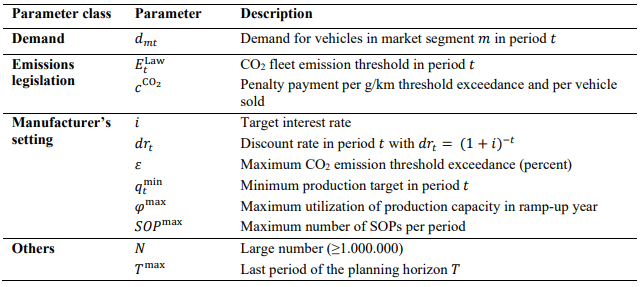

In [9]:
#Demand
df_demand = df_demand.set_index('Market Segments')
dmt = df_demand.stack()

In [10]:
#Emissions legislation
EtLaw = df_emissionsthreshold['Threshold']
cCO2 = df_parameters[df_parameters["Parameter"] == "C^CO2"]["Value"].values[0]

In [11]:
#Manufacturers setting
i = df_parameters[df_parameters["Parameter"] == "i"]["Value"].values[0]/100
epsilon = 1 #either 0% or 100%
qtmin = df_parameters[df_parameters["Parameter"] == "q_t^min"]["Value"].values[0] #the same value for all periods
fimax = df_parameters[df_parameters["Parameter"] == "Fi^max"]["Value"].values[0] #the same value for all periods
SOPmax = 6 #Assume it's 6 at most

#calculating the discount rate
discount_dict = {'Period':T, 'Discount Year': T-min(T)} #Assume the current year is min(T)
df_discountrate = pd.DataFrame(data = discount_dict)
df_discountrate.set_index('Period', inplace = True)
df_discountrate["discountrate"] = (1 + i)**-df_discountrate["Discount Year"]
drt = df_discountrate["discountrate"]

In [12]:
#Others
N = 10000000
Tmax = T.max()

### Decision variables
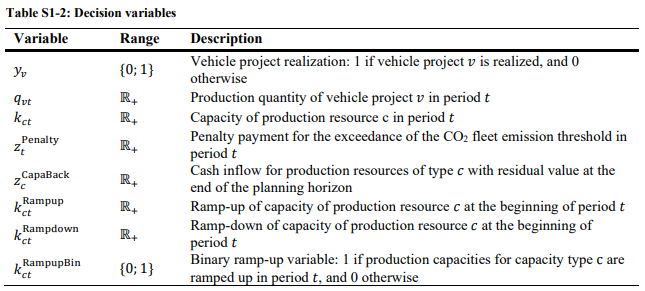

In [13]:
yv = model.addVars(V, name = "yv", vtype=GRB.BINARY)
qvt = model.addVars(V, T, name = "qvt", vtype=GRB.INTEGER, lb = 0)
kct = model.addVars(C, T, name = "kct", vtype=GRB.INTEGER, lb = 0)
kctRampup = model.addVars(C, T, name = "kctRampup", vtype=GRB.INTEGER, lb = 0)
kctRampdown = model.addVars(C, T, name = "kctRampdown", vtype=GRB.INTEGER, lb = 0)
#qvt = model.addVars(V, T, name = "qvt", vtype=GRB.CONTINUOUS, lb = 0)
#kct = model.addVars(C, T, name = "kct", vtype=GRB.CONTINUOUS, lb = 0)
ztPenalty = model.addVars(T, name = "ztPenalty", vtype=GRB.CONTINUOUS, lb = 0)
zcCapaBack = model.addVars(C, name = "zcCapaBack", vtype=GRB.CONTINUOUS, lb = 0)
#kctRampup = model.addVars(C, T, name = "kctRampup", vtype=GRB.CONTINUOUS, lb = 0)
#kctRampdown = model.addVars(C, T, name = "kctRampdown", vtype=GRB.CONTINUOUS, lb = 0)
kctRampupBin = model.addVars(C, T, name = "kctRampupBin", vtype=GRB.BINARY)
model.update()

### Objective Function
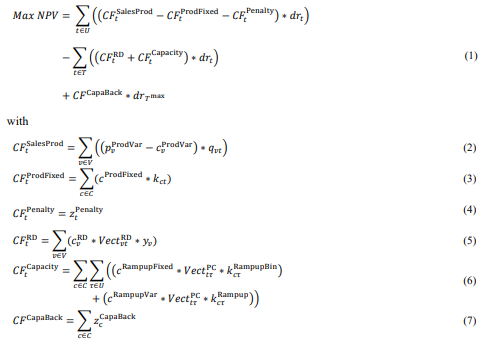

In [14]:
CFtSalesProd = {}
CFtProdFixed = {}
CFtPenalty = {}
CFtRD = {}
CFtCapacity = {}
for t in T:
# Calculate the summation
    CFtSalesProd[t] = gp.quicksum((pvProdVar[v] - cvProdVar[v]) * qvt[v,t] for v in V)
    CFtProdFixed[t] = sum((cProdFixed)*kct[c,t] for c in C)
    CFtPenalty[t] = ztPenalty[t]
    
    #Calculate RD cashflow
    for v in V:
        if t in VectvtRD.loc[v].index.get_level_values('Period'):
            if t in CFtRD:
                CFtRD[t] += cRD*VectvtRD.loc[(v,t)].values[0]*yv[v]
            else:
                CFtRD[t] = cRD*VectvtRD.loc[(v,t)].values[0]*yv[v]
    #Calculate Production Capacity rampup cashflow
    for tau in U:
        if t in VectttauPC.loc[tau].index.get_level_values('Period(t)'):
            if t in CFtCapacity:
                CFtCapacity[t] += sum(cRampupFixed*VectttauPC.loc[(tau,t)].values[0]*kctRampupBin[c,tau] 
                                     + cRampupVar*VectttauPC.loc[(tau,t)].values[0]*kctRampup[c,tau] for c in C)
            else:
                CFtCapacity[t] = sum(cRampupFixed*VectttauPC.loc[(tau,t)].values[0]*kctRampupBin[c,tau] 
                                     + cRampupVar*VectttauPC.loc[(tau,t)].values[0]*kctRampup[c,tau] for c in C)
CFCapaBack = sum(zcCapaBack[c] for c in C)
#add variables to the Gurobi model
#for t in T:
#     model.addVar(name=f"CFtSalesProd_{t}", obj=CFtSalesProd[t], vtype=GRB.CONTINUOUS)
    #model.addVar(name=f"CFtRD_{t}", obj=CFtRD[t], vtype=GRB.CONTINUOUS)
model.update


<bound method Model.update of <gurobi.Model MIP instance Unnamed: 0 constrs, 19024 vars, Parameter changes: Username=(user-defined), LicenseID=2441550>>

In [15]:
NPV =  sum((CFtSalesProd[t] - CFtProdFixed[t] - CFtPenalty[t])*drt[t] for t in U) - sum(drt[t] * CFtRD[t] for t in CFtRD) - sum(drt[t] * CFtCapacity[t] for t in CFtCapacity) + drt[Tmax] * CFCapaBack

model.setObjective(NPV, sense=GRB.MAXIMIZE)
model.ModelSense = GRB.MAXIMIZE
model.update()

### Constraints
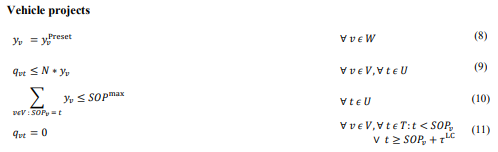

In [16]:
for v in W:
  model.addConstr(yv[v] ==yvpreset.loc[v], name=f'ct8{v}') #Constraint (8)
for v in V:
  for t in U:
    model.addConstr(qvt[v, t]<= N * yv[v], name=f'ct9{v,t}') #Constraint (9)
for t in U:
  model.addConstr(sum(yv[v] for v in SOPv[SOPv == t].index) <= SOPmax, name=f'ct10{t}') #Constraint (10)
for t in T:
  for v in SOPv[(SOPv > t) | (SOPv + tauLC <= t)].index:
    model.addConstr(qvt[v,t] == 0, name=f'ct10{v,t}') #Constraint (11)

model.update()

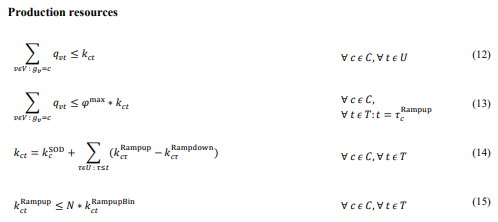\
\
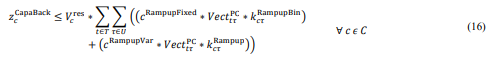

In [17]:
for t in U:
    for c in C:
        model.addConstr(sum(qvt[v,t] for v in gv[gv == c].index) <= kct[c,t], name=f'ct12{c,t}') #Constraint (12)
for c in C:
    for t in [x for x in T if t in taucRampup.loc[c]]:
        model.addConstr(sum(qvt[v,t] for v in gv[gv == c].index) <= fimax * kct[c,t], name=f'ct13{c,t}') #Constraint (13)
for c in C:
    for t in T:
        model.addConstr(kct[c,t] == kcSOD.at[c, 'Capacity in 2025'] + sum((kctRampup[c,tau]-kctRampdown[c,tau]) for tau in U if tau <= t), name=f'ct14{c,t}') #Constraint (14)
        #model.addConstr(kctRampup[c,t] <= N * kctRampupBin[c,t], name=f'ct15{c,t}') #Constraint (15)
        if t in U:
          model.addConstr(kctRampup[c,t] <= N * kctRampupBin[c,t], name=f'ct15{c,t}') #Constraint (15)

CResidual = {}
depreciation = 1/tauRampup
for c in C:
    for tau in U:
        if tau > Tmax - tauRampup: #only in the last years there is remaining value
            if c in CResidual:
                CResidual[c] += (cRampupFixed*kctRampupBin[c,tau] + cRampupVar*kctRampup[c,tau])*(1 - (Tmax-tau)*depreciation) #full value* (1- depreciation so far)
            else:
                CResidual[c] = (cRampupFixed*kctRampupBin[c,tau] + cRampupVar*kctRampup[c,tau])*(1 - (Tmax-tau)*depreciation) #full value* (1- depreciation so far)
    model.addConstr(zcCapaBack[c] <= Vcres * CResidual[c], name=f'ct16{c}') #Constraint (16)

model.update()

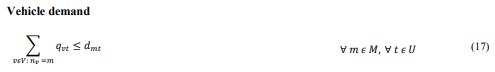

In [18]:
for m in M:
    for t in U:
        model.addConstr(sum(qvt[v,t] for v in nv[nv == m].index) <= dmt.loc[m,t], name=f'ct17{m,t}') #Constraint (17)
model.update()

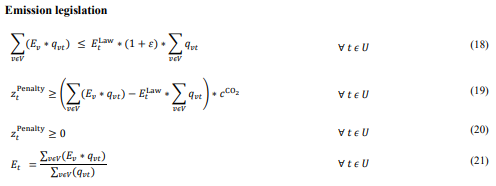

In [19]:
for t in U:
    model.addConstr(sum(Ev[v] * qvt[v,t] for v in V) <= EtLaw[t] * (1 + epsilon) * sum(qvt[v,t] for v in V), name=f'ct18 {t}') #Constraint (18)
    model.addConstr(ztPenalty[t] >= ((sum(Ev[v] * qvt[v,t] for v in V) - EtLaw[t] * sum(qvt[v,t] for v in V)) * cCO2), name=f'ct19 {t}') #Constraint (19)
    model.addConstr(ztPenalty[t] >= 0, name=f'ct20{t}') #Constraint (20)
    #Equation 21 is not a constraint. It is just for caluculating purposes.
model.update()

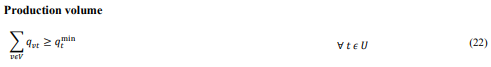

In [20]:
for t in U:
    model.addConstr(sum(qvt[v,t] for v in V) >= qtmin, name=f'ct22 {t}') #Constraint (22)
model.update()

### Solve model

In [21]:
#Output debug file for model visualisation
#model.write("debug.lp")
# Optimize the model
model.optimize()
ObjBasic = model.ObjVal

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2441550 - for non-commercial use only - registered to so___@tum.de
Optimize a model with 15338 rows, 19024 columns and 63308 nonzeros
Model fingerprint: 0x5bae0211
Variable types: 208 continuous, 18816 integer (3456 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+07]
  Objective range  [5e-01, 3e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 11599 rows and 13944 columns
Presolve time: 0.23s
Presolved: 3739 rows, 5080 columns, 21739 nonzeros
Variable types: 10 continuous, 5070 integer (1449 binary)
Found heuristic solution: objective -7.36263e+11

Root relaxation: objective 7.604886e+10, 1645 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

In [22]:
"""
constrs = model.getConstrs()
for c in constrs:
    if 'ct17' in c.ConstrName:
        if c.Slack != 0: 
            print(c.ConstrName)
"""

"\nconstrs = model.getConstrs()\nfor c in constrs:\n    if 'ct17' in c.ConstrName:\n        if c.Slack != 0: \n            print(c.ConstrName)\n"

In [23]:

"""
def check_feasibility(mod):
    #mod.optimize()
    
    if mod.status == GRB.OPTIMAL:
        print("Feasible solution found.")
    else:
        print("No feasible solution found.")

def check_optimality(mod):
    if mod.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        # Compare solution with expectations and goals


def integer_feasibility_check(mod):
    # Check if the solution is integer
    integer_feasible = all(var.X % 1 == 0 for var in mod.getVars() if var.VType == GRB.INTEGER)
    
    if integer_feasible:
        print("Solution is integer feasible.")
    else:
        print("Solution is not integer feasible. Consider adjusting MIP parameters.")

def performance_metrics(mod):
    print(f"Solved in {mod.Runtime:.2f} seconds.")
    

# Conduct Sanity Check
check_feasibility(model)
check_optimality(model)
integer_feasibility_check(model)
performance_metrics(model)
"""

'\ndef check_feasibility(mod):\n    #mod.optimize()\n    \n    if mod.status == GRB.OPTIMAL:\n        print("Feasible solution found.")\n    else:\n        print("No feasible solution found.")\n\ndef check_optimality(mod):\n    if mod.status == GRB.OPTIMAL:\n        print("Optimal solution found.")\n        # Compare solution with expectations and goals\n\n\ndef integer_feasibility_check(mod):\n    # Check if the solution is integer\n    integer_feasible = all(var.X % 1 == 0 for var in mod.getVars() if var.VType == GRB.INTEGER)\n    \n    if integer_feasible:\n        print("Solution is integer feasible.")\n    else:\n        print("Solution is not integer feasible. Consider adjusting MIP parameters.")\n\ndef performance_metrics(mod):\n    print(f"Solved in {mod.Runtime:.2f} seconds.")\n    \n\n# Conduct Sanity Check\ncheck_feasibility(model)\ncheck_optimality(model)\ninteger_feasibility_check(model)\nperformance_metrics(model)\n'

In [24]:
#model.Params.SolFiles = 'mymodel'
#model.write('mymodel.sol')

##### Write Results into Excel

In [25]:
"""
qvtResult ={"Project, Year": [], "Production Qunatity": []}
for key, var in qvt.items():
    qvtResult["Project, Year"].append(key)
    qvtResult["Production Qunatity"].append(var.X)
df_qvtResult = pd.DataFrame.from_dict(qvtResult)
#Extract out project and year
df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].astype(str).str.replace("('", "")
df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].str.replace(")", "")
qvt_project = []
qvt_year = []
for i in df_qvtResult["Project, Year"].str.split(pat="', "):
    qvt_project.append(i[0])
    qvt_year.append(i[1])
df_qvtResult["Project"] = qvt_project
df_qvtResult["Year"] = qvt_year
df_qvtResult.drop(columns='Project, Year', inplace=True)
df_qvtResult = df_qvtResult.pivot(index="Project", columns = "Year", values = "Production Qunatity")
"""

'\nqvtResult ={"Project, Year": [], "Production Qunatity": []}\nfor key, var in qvt.items():\n    qvtResult["Project, Year"].append(key)\n    qvtResult["Production Qunatity"].append(var.X)\ndf_qvtResult = pd.DataFrame.from_dict(qvtResult)\n#Extract out project and year\ndf_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].astype(str).str.replace("(\'", "")\ndf_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].str.replace(")", "")\nqvt_project = []\nqvt_year = []\nfor i in df_qvtResult["Project, Year"].str.split(pat="\', "):\n    qvt_project.append(i[0])\n    qvt_year.append(i[1])\ndf_qvtResult["Project"] = qvt_project\ndf_qvtResult["Year"] = qvt_year\ndf_qvtResult.drop(columns=\'Project, Year\', inplace=True)\ndf_qvtResult = df_qvtResult.pivot(index="Project", columns = "Year", values = "Production Qunatity")\n'

In [26]:
"""
def extract_results():
    #yv
    yvResult = {"Project": [], "Realized or not": []}
    for key, var in yv.items():
        yvResult["Project"].append(key)
        yvResult["Realized or not"].append(var.X)
    df_yvResult = pd.DataFrame.from_dict(yvResult)
    df_yvResult.set_index("Project", inplace=True)
    #qvt
    qvtResult ={"Project, Year": [], "Production Qunatity": []}
    for key, var in qvt.items():
        qvtResult["Project, Year"].append(key)
        qvtResult["Production Qunatity"].append(var.X)
    df_qvtResult = pd.DataFrame.from_dict(qvtResult)
    #df_qvtResult.set_index("Project, Year", inplace=True)
    #Extract out project and year
    df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].astype(str).str.replace("('", "")
    df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].str.replace(")", "")
    qvt_project = []
    qvt_year = []
    for i in df_qvtResult["Project, Year"].str.split(pat="', "):
        qvt_project.append(i[0])
        qvt_year.append(i[1])
    df_qvtResult["Project"] = qvt_project
    df_qvtResult["Year"] = qvt_year
    #df_qvtResult.drop(columns='Project, Year', inplace=True)
    #df_qvtResult = df_qvtResult.pivot(index="Project", columns = "Year", values = "Production Qunatity")
    #kct, kctRampupBin, kctRampup, kctRampdown
    kctResult = {"Resource, Year": [], "Production Capacity": [], "Ramp-up Binary": [], "Ramp-up Capacity": [], "Ramp-down Capacity": []}
    for key, var in kct.items():
        kctResult["Resource, Year"].append(key)
        kctResult["Production Capacity"].append(var.X)
        kctResult["Ramp-up Binary"].append(kctRampupBin[key].X)
        kctResult["Ramp-up Capacity"].append(kctRampup[key].X)
        kctResult["Ramp-down Capacity"].append(kctRampdown[key].X)
    df_kctResult = pd.DataFrame.from_dict(kctResult)
    #df_kctResult.set_index("Resource, Year", inplace=True) #Uncomment this 
    #Extract out resource and year
    df_kctResult["Resource, Year"] = df_kctResult["Resource, Year"].astype(str).str.replace("('", "")
    df_kctResult["Resource, Year"] = df_kctResult["Resource, Year"].str.replace(")", "")
    kct_resource = []
    kct_year = []
    for i in df_kctResult["Resource, Year"].str.split(pat="', "):
        kct_resource.append(i[0])
        kct_year.append(i[1])
    df_kctResult["Resource"] = kct_resource
    df_kctResult["Year"] = kct_year
    #df_kctResult.drop(columns='Resource, Year', inplace=True)
    #df_kctResult = df_kctResult.pivot(index="Resource", columns = "Year", values = ["Production Capacity", "Ramp-up Binary", "Ramp-up Capacity", "Ramp-down Capacity"])
    frames = {'Project Realization':df_yvResult, 'Production Quantity':df_qvtResult,'kctResults':df_kctResult}
    return frames

def write_Results_to_excel(x,path):
    # Create a Pandas Excel writer using ExcelWriter
    with pd.ExcelWriter(path) as writer:
    # Write each DataFrame to a different worksheet
        for key, df in x.items():
            df.to_excel(writer, sheet_name=key, index=True)
      
Results_basic = extract_results()
write_Results_to_excel(Results_basic,'Results_BasicModel.xlsx')
"""

'\ndef extract_results():\n    #yv\n    yvResult = {"Project": [], "Realized or not": []}\n    for key, var in yv.items():\n        yvResult["Project"].append(key)\n        yvResult["Realized or not"].append(var.X)\n    df_yvResult = pd.DataFrame.from_dict(yvResult)\n    df_yvResult.set_index("Project", inplace=True)\n    #qvt\n    qvtResult ={"Project, Year": [], "Production Qunatity": []}\n    for key, var in qvt.items():\n        qvtResult["Project, Year"].append(key)\n        qvtResult["Production Qunatity"].append(var.X)\n    df_qvtResult = pd.DataFrame.from_dict(qvtResult)\n    #df_qvtResult.set_index("Project, Year", inplace=True)\n    #Extract out project and year\n    df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].astype(str).str.replace("(\'", "")\n    df_qvtResult["Project, Year"] = df_qvtResult["Project, Year"].str.replace(")", "")\n    qvt_project = []\n    qvt_year = []\n    for i in df_qvtResult["Project, Year"].str.split(pat="\', "):\n        qvt_project.

In [30]:

def retreive_yv():
    #yv
    yvResult = {"Project": [], "Realized or not": []}
    for key, var in yv.items():
        yvResult["Project"].append(key)
        yvResult["Realized or not"].append(var.X)
    df_yvResult = pd.DataFrame.from_dict(yvResult)
    df_yvResult.set_index("Project", inplace=True)
    return df_yvResult


## Experiment study 

### Create experiment study function - Change Development Cost

In [27]:
def change_dev_cost(x):
    CFtRD = {}
    for t in T:
        for v in V:
            if t in VectvtRD.loc[v].index.get_level_values('Period'):
                if t in CFtRD:
                    CFtRD[t] += x[v]*VectvtRD.loc[(v,t)].values[0]*yv[v]
                else:
                    CFtRD[t] = x[v]*VectvtRD.loc[(v,t)].values[0]*yv[v]
    NPV = sum((CFtSalesProd[t] - CFtProdFixed[t] - CFtPenalty[t])*drt[t] for t in U) - sum(drt[t] * CFtRD[t] for t in CFtRD)-sum(drt[t] * CFtCapacity[t] for t in CFtCapacity) + drt[Tmax] * CFCapaBack
    model.setObjective(NPV, sense=GRB.MAXIMIZE)
    model.ModelSense = GRB.MAXIMIZE
    model.update()
    model.optimize()
    return model

def dispose(model):
    model.dispose()
    gp.disposeDefaultEnv()

### Create development cost for each project: cRDVar

In [28]:
def create_cRDVar(ICEV, PHEV, BEV, FCEV):
    #Extract out the engine type for each project
    engine = []
    for i in df_vehicle.index.str.split(pat="_"):
            engine.append(i[1]) 
    df_vehicle['Engine Type'] = engine
    #Matching development cost to corresponding engine type
    DevelopmentCostSetting = {"ICEV": cRD*ICEV, "PHEV": cRD*PHEV, "BEV": cRD*BEV, "FCEV": cRD*FCEV}
    cRDVar = df_vehicle['Engine Type'].map(DevelopmentCostSetting)
    return cRDVar

### Run scenario analysis with changing one parameter gradually at a time

In [34]:
Scenario = [create_cRDVar(0.6, 1, 1, 1), create_cRDVar(0.8, 1, 1, 1), create_cRDVar(1.2, 1, 1, 1), create_cRDVar(1.4, 1, 1, 1),\
            create_cRDVar(1, 0.6, 1, 1), create_cRDVar(1, 0.8, 1, 1), create_cRDVar(1, 1.2, 1, 1),  create_cRDVar(1, 1.4, 1, 1),\
            create_cRDVar(1, 1, 0.6, 1), create_cRDVar(1, 1, 0.8, 1), create_cRDVar(1, 1, 1.2, 1),  create_cRDVar(1, 1, 1.4, 1),\
            create_cRDVar(1, 1, 1, 0.6), create_cRDVar(1, 1, 1, 0.8), create_cRDVar(1, 1, 1, 1.2),  create_cRDVar(1, 1, 1, 1.4)
                ]
"""
Scenario = [create_cRDVar(1, 1, 1, 1),\
            create_cRDVar(0.9, 1, 0.9, 0.9), create_cRDVar(1.1, 1, 0.9, 0.9), create_cRDVar(0.9, 1, 1.1, 0.9), create_cRDVar(0.9, 1, 0.9, 1.1), create_cRDVar(1.1, 1, 1.1, 0.9), \
            create_cRDVar(1.1, 1, 0.9, 1.1), create_cRDVar(0.9, 1, 1.1, 1.1),  create_cRDVar(1.1, 1, 1.1, 1.1),\
                ]
"""
ObjScenarios = []
yvScenarios =  pd.DataFrame()
for i in range(len(Scenario)):
    model_cRDVar = change_dev_cost(Scenario[i])
    ObjScenarios.append(model_cRDVar.objVal)
    yvScenarios[i] = retreive_yv()
    #Results_changedcRD = extract_results()
    #write_Results_to_excel(Results_changedcRD,f'Results_changedcRD{i}.xlsx')
    

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2441550 - for non-commercial use only - registered to so___@tum.de
Optimize a model with 15338 rows, 19024 columns and 63308 nonzeros
Model fingerprint: 0xbcae7872
Variable types: 208 continuous, 18816 integer (3456 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+07]
  Objective range  [5e-01, 3e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

MIP start from previous solve produced solution with objective 7.68867e+10 (0.12s)
Loaded MIP start from previous solve with objective 7.68867e+10

Presolve removed 11599 rows and 13944 columns
Presolve time: 0.26s
Presolved: 3739 rows, 5080 columns, 21739 nonzeros
Variable types: 10 continuous, 5070 integer (1449 binary)

Root relaxation: objective 7.728326e+10, 1638 iterations,

### Visualization: NPV

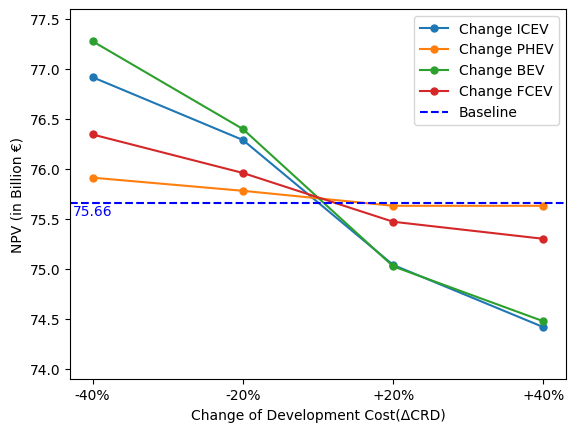

In [40]:

n = int(len(Scenario)/4)
fig = plt.figure()
ax = fig.add_subplot(111)
#for i in (range(0,len(Scenario)-1,n)):
#    plt.plot(range(1,n+1), [x /(10**9) for x in ObjScenarios[1+i:1+n+i]],  marker = '.', markersize = 10, label = "%d" %(i/n+1))
plt.plot(range(1,n+1), [x /(10**9) for x in ObjScenarios[0:n]],  marker = '.', markersize = 10, label = 'Change ICEV')
plt.plot(range(1,n+1), [x /(10**9) for x in ObjScenarios[n:2*n]],  marker = '.', markersize = 10, label = 'Change PHEV')
plt.plot(range(1,n+1), [x /(10**9) for x in ObjScenarios[2*n:3*n]],  marker = '.', markersize = 10, label = 'Change BEV')
plt.plot(range(1,n+1), [x /(10**9) for x in ObjScenarios[3*n:len(Scenario)]],  marker = '.', markersize = 10, label = 'Change FCEV')
plt.axhline(y=ObjBasic/(10**9), color='b', linestyle='--', label = "Baseline")
ax.text(1, ObjBasic/(10**9)-0.12, "%.2f" %(ObjBasic/(10**9)), ha="center", color = "b")
plt.ylabel("NPV (in Billion €)")
plt.xlabel("Change of Development Cost(\u0394CRD)")
#for i, v in enumerate([x /(10**9) for x in np.delete(ObjScenarios,0)]):
#    ax.text(i+1, v+0.04, "%.2f" %v, ha="center")
plt.ylim(73.9, 77.6)
ax.set_xticks(range(1,n+1))
#ax.set_xticks(range(1,len(Scenario)))
ax.set_xticklabels(["-40%", "-20%", "+20%", "+40%"])
plt.legend()
#plt.title("Change Development Cost Ceteris Paribus")


Text(0.5, 0, 'Combination')

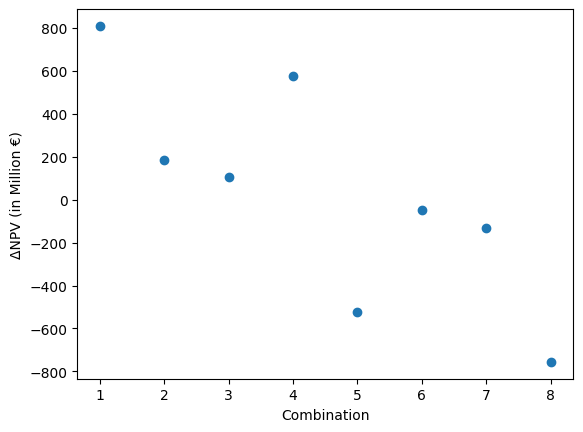

In [32]:

fig = plt.figure()
#ax = fig.add_subplot(111)
plt.scatter(range(1,len(Scenario)),[(x-ObjBasic) /(10**6) for x in ObjScenarios[1:len(Scenario)]])
plt.ylabel("\u0394NPV (in Million €)")
plt.xlabel("Combination")
#plt.title("Result of Factorial Experiment")

#### Calculate the NPV difference of each scenario

In [57]:
NPV_diff = []
NPV_diff_per = []
for i in range(len(Scenario)):
    NPV_diff.append((ObjScenarios[i] - ObjBasic)/10**6)
    NPV_diff_per.append(100*(ObjScenarios[i] - ObjBasic)/ObjBasic)
NPVDifference = pd.DataFrame()
NPVDifference['Million euro'] = NPV_diff
NPVDifference['%']=NPV_diff_per
NPVDifference

,Million euro,%
0,0.000000,0.000000
1,809.862019,1.070372
2,184.540363,0.243902
3,103.593019,0.136916
4,575.720252,0.760913
5,-521.728894,-0.689554
6,-49.601404,-0.065557
7,-130.549005,-0.172543
8,-755.870661,-0.999013


In [30]:
"""
CF_SP = pd.DataFrame()
CF_SP['Period'] = U
CF_Fix = pd.DataFrame()
CF_Fix['Period'] = U
CF_RD = pd.DataFrame()
CF_RD['Period'] = np.delete(U, 9)
CF_Cap = pd.DataFrame()
CF_Cap['Period'] = np.delete(U, 9)
CF_Pen = pd.DataFrame()
CF_Pen['Period'] = np.delete(U, 9)
CF_Pen['Baseline'] = [CFtPenalty[t].X for t in np.delete(U, 9)]
CF_SP['Baseline'] = [CFtSalesProd[t].getValue() for t in U]
CF_Fix['Baseline'] = [CFtProdFixed[t].getValue() for t in U]
CF_RD['Baseline'] = [CFtRD[t].getValue() for t in np.delete(U, 9)]
CF_Cap['Baseline'] = [CFtCapacity[t].getValue() for t in np.delete(U, 9)]
"""

In [31]:
"""
model_Scen1 = change_dev_cost(Scenario[0])
Results_Scen1 = extract_results()
CF_SP['Scenario 1'] = [CFtSalesProd[t].getValue() for t in U]
CF_Fix['Scenario 1'] = [CFtProdFixed[t].getValue() for t in U]
CF_RD['Scenario 1'] =  [CFtProdFixed[t].getValue() for t in np.delete(U, 9)]
CF_Cap['Scenario 1'] =  [CFtCapacity[t].getValue() for t in np.delete(U, 9)]
CF_Pen['Scenario 1'] =  [CFtPenalty[t].X for t in np.delete(U, 9)]
"""

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2441550 - for non-commercial use only - registered to so___@tum.de
Optimize a model with 15338 rows, 19024 columns and 63308 nonzeros
Model fingerprint: 0x5bae0211
Variable types: 208 continuous, 18816 integer (3456 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+07]
  Objective range  [5e-01, 3e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

MIP start from previous solve produced solution with objective 7.5642e+10 (0.05s)
Loaded MIP start from previous solve with objective 7.5642e+10

Presolve removed 11599 rows and 13944 columns
Presolve time: 0.17s
Presolved: 3739 rows, 5080 columns, 21739 nonzeros
Variable types: 10 continuous, 5070 integer (1449 binary)

Root relaxation: objective 7.604886e+10, 1645 iterations, 0

In [32]:
"""
model_Scen2 = change_dev_cost(Scenario[1])
Results_Scen2 = extract_results()
CF_SP['Scenario 2'] = [CFtSalesProd[t].getValue() for t in U]
CF_Fix['Scenario 2'] = [CFtProdFixed[t].getValue() for t in U]
CF_RD['Scenario 2'] =  [CFtProdFixed[t].getValue() for t in np.delete(U, 9)]
CF_Cap['Scenario 2'] =  [CFtCapacity[t].getValue() for t in np.delete(U, 9)]
CF_Pen['Scenario 2'] =  [CFtPenalty[t].X for t in np.delete(U, 9)]
"""

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2441550 - for non-commercial use only - registered to so___@tum.de
Optimize a model with 15338 rows, 19024 columns and 63308 nonzeros
Model fingerprint: 0xbcae7872
Variable types: 208 continuous, 18816 integer (3456 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+07]
  Objective range  [5e-01, 3e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

MIP start from previous solve produced solution with objective 7.69074e+10 (0.05s)
Loaded MIP start from previous solve with objective 7.69074e+10

Presolve removed 11599 rows and 13944 columns
Presolve time: 0.17s
Presolved: 3739 rows, 5080 columns, 21739 nonzeros
Variable types: 10 continuous, 5070 integer (1449 binary)

Root relaxation: objective 7.728326e+10, 1638 iterations,

In [33]:
"""
model_Scen3 = change_dev_cost(Scenario[2])
Results_Scen3 = extract_results()
CF_SP['Scenario 3'] = [CFtSalesProd[t].getValue() for t in U]
CF_Fix['Scenario 3'] = [CFtProdFixed[t].getValue() for t in U]
CF_RD['Scenario 3'] =  [CFtProdFixed[t].getValue() for t in np.delete(U, 9)]
CF_Cap['Scenario 3'] =  [CFtCapacity[t].getValue() for t in np.delete(U, 9)]
CF_Pen['Scenario 3'] =  [CFtPenalty[t].X for t in np.delete(U, 9)]
"""

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license 2441550 - for non-commercial use only - registered to so___@tum.de
Optimize a model with 15338 rows, 19024 columns and 63308 nonzeros
Model fingerprint: 0x2dbddbb5
Variable types: 208 continuous, 18816 integer (3456 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+07]
  Objective range  [5e-01, 3e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

MIP start from previous solve produced solution with objective 7.62899e+10 (0.06s)
Loaded MIP start from previous solve with objective 7.62899e+10

Presolve removed 11599 rows and 13944 columns
Presolve time: 0.29s
Presolved: 3739 rows, 5080 columns, 21739 nonzeros
Variable types: 10 continuous, 5070 integer (1449 binary)

Root relaxation: objective 7.666374e+10, 1644 iterations,

### Visualization: yv

In [37]:
def count_yv(df_yv):
    n = len(Scenario)
    engine = []
    year = []
    count = pd.DataFrame()#(columns = ["ICEV","PHEV","BEV","FCEV"])
    #count = {'ICEV':0, 'PHEV':0, 'BEV':0, 'FCEV':0}
    for i in df_yv.index.str.split(pat="_"):
        #df_yv['Engine Type'].tolist().append(i[1])
        engine.append(i[1])
        year.append(i[-1])
    df_yv['Engine Type'] = engine
    df_yv['Project Year'] = year 
    df_yv = df_yv.drop(df_yv[df_yv['Project Year'].astype(int)<2025].index)
    for i in np.delete(df_yv.columns,[n,n+1]):
        count[i] = df_yv[df_yv[i] == 1]['Engine Type'].value_counts()
    return count
count_yv(yvScenarios)

,0,1,2,3,4,5,6,7,8
Engine Type,,,,,,,,,
BEV,11,12,12,11,12,11,12,11,11
ICEV,10,10,10,10,10,10,10,10,10
FCEV,4,6,6,6,3,6,3,3,3
PHEV,2,2,2,2,2,2,2,2,2


In [ ]:
LineBaseline = sorted(count_yv(Results_basic).items())
LineScen1= sorted(count_yv(Results_Scen1).items())
LineScen2= sorted(count_yv(Results_Scen2).items())
LineScen3= sorted(count_yv(Results_Scen3).items())
x, y = zip(*LineBaseline)
x, z = zip(*LineScen1)
x, w = zip(*LineScen2)
x, u = zip(*LineScen3)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(4)
ax1.bar(ind-0.3, y, width=0.2, color='b', align='center', label='Baseline')
ax1.bar(ind-0.1, z, width=0.2, color='orange', align='center', label='Scenario 1')
ax1.bar(ind+0.1, w, width=0.2, color='g', align='center', label='Scenario 2')
ax1.bar(ind+0.3, u, width=0.2, color='r', align='center', label='Scenario 3')
ax1.set_xticks(ind)
ax1.set_xticklabels(x)

plt.legend(loc='upper right')
plt.yticks(range(0,21,2))
plt.ylabel("Number of Realized Projects")
plt.xlabel("Powertrain Type")
plt.title("Number of realized projects under different scenarios")
plt.show()

### Visualization: Cash Flow

<Axes: title={'center': 'CF Sales & Production'}, xlabel='Period'>

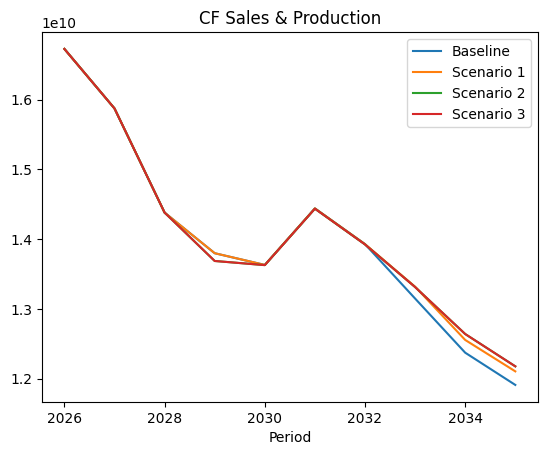

In [37]:
CF_SP.set_index('Period', inplace=True)
CF_SP.plot(title="CF Sales & Production")

<Axes: title={'center': 'CF Penalty'}, xlabel='Period'>

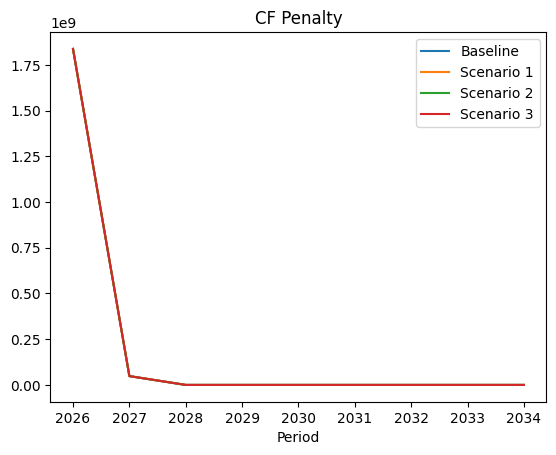

In [38]:
CF_Pen.set_index('Period', inplace=True)
CF_Pen.plot(title="CF Penalty")

<Axes: title={'center': 'Cash Flow Development'}, xlabel='Year', ylabel='million €'>

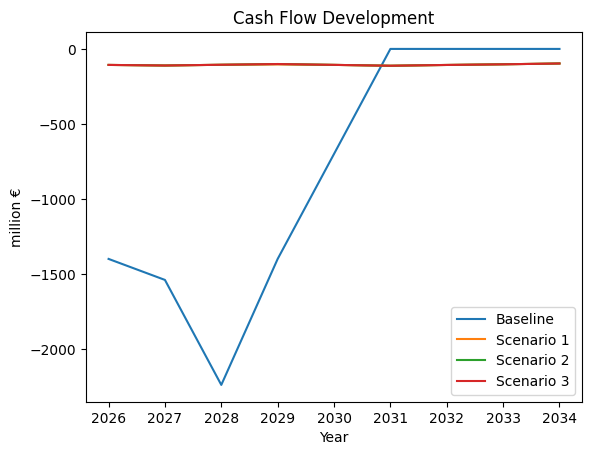

In [39]:
CF_RD.set_index('Period', inplace=True)
CF_RD.mul(-1e-6).plot(ylabel = "million €", xlabel='Year', title ="Cash Flow Development")

<Axes: title={'center': 'Cash Flow Development'}, xlabel='Year', ylabel='million €'>

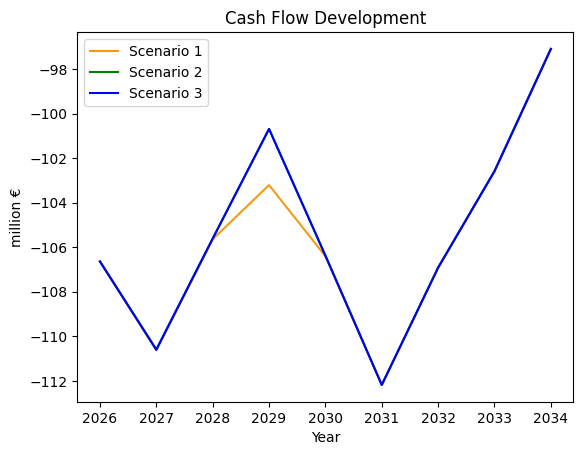

In [40]:
color_dict = {'rScenario 1': '#F39C12', 'Scenario 2': 'g', 'Scenario 3': 'b'}
CF_RD[["Scenario 1","Scenario 2","Scenario 3"]].mul(-10**-6).plot(ylabel = "million €", xlabel='Year', title ="Cash Flow Development", color = [color_dict.get(x, '#F39C12') for x in ["Scenario 1","Scenario 2","Scenario 3"]])

<Axes: title={'center': 'CF Fixed Cost'}, xlabel='Period'>

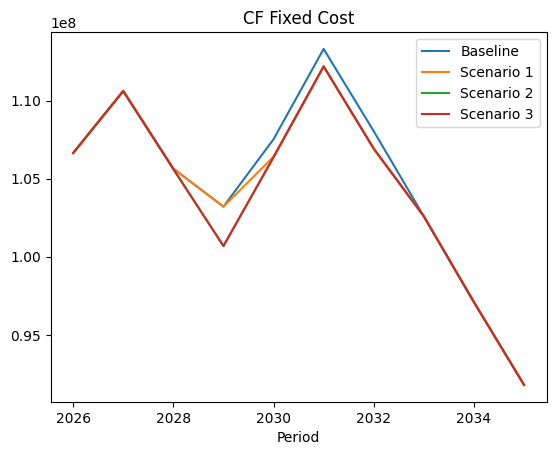

In [41]:
CF_Fix.set_index('Period', inplace=True)
CF_Fix.plot(title="CF Fixed Cost")

<Axes: title={'center': 'CF Capacity Rampup Cost'}, xlabel='Period'>

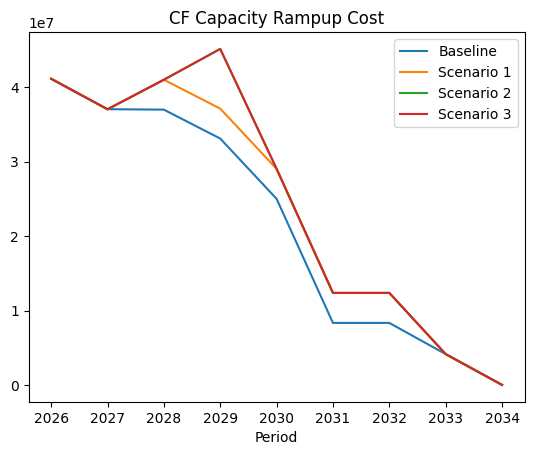

In [42]:
CF_Cap.set_index('Period', inplace=True)
CF_Cap.plot(title="CF Capacity Rampup Cost")

In [43]:
"""This is to run the model over several instances with constant cRD
lObj = []
lyv = dict.fromkeys(range(1,11))
for x in range(1,11):
    model_instance = change_dev_cost(1+x/10)
    #print("If development cost is", x*cRD," CFRD at 2027 becomes " , CFtRD[2027].getValue(), ", then the objective function becomes", model_instance.objVal)
    lObj.append(model_instance.objVal)
    lyv[x]=[yv[v].X for v in V]
"""

'This is to run the model over several instances with constant cRD\nlObj = []\nlyv = dict.fromkeys(range(1,11))\nfor x in range(1,11):\n    model_instance = change_dev_cost(1+x/10)\n    #print("If development cost is", x*cRD," CFRD at 2027 becomes " , CFtRD[2027].getValue(), ", then the objective function becomes", model_instance.objVal)\n    lObj.append(model_instance.objVal)\n    lyv[x]=[yv[v].X for v in V]\n'